In [1]:
import numpy as np
import math
import collections
import time
import random

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import LeaveOneOut, cross_val_score, GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt

### Data Prep

In [2]:
#returns
#    array of sample IDs (0-100)
#    2D array of sample SNP data 
#    array of sample positions in genome to be used as feature names
#    array of counts of samples that have SNPs in that position
def parse_SNPs(fn):
    f = open(fn)

    sample_IDs_ws = f.readline().split("\t")[2:]
    sample_IDs = [s.strip() for s in sample_IDs_ws]
    
    num_samples = len(sample_IDs)  #100
    samples = []  #SNP data for each sample
    positions = []  #positions in genome (from "catalog ID")
    counts = []
    
    for i in range(num_samples):
        samples.append([])
    
    for line in f.readlines():
        split = line.split("\t")
        positions.append(split[0])
        counts.append(split[1])
        for i, s in enumerate(split[2:]):
            samples[i].append(s.strip())
            
    return sample_IDs, samples, positions, counts

In [3]:
#returns array of labels
def parse_labels(fn):
    f = open(fn, 'r', encoding='utf-8-sig')
    labels = [None] * 100 #initializing list so sample plant_types can be added in correct positions based on ID
    
    #store plant types in positions based on sample ID
    for line in f.readlines():
        split = line.split(",")
        i = sample_IDs.index(split[0]) #sample position
        labels[i] = split[2]
    
    return labels

In [4]:
sample_IDs, samples, positions, counts = parse_SNPs('SNPs.txt')
labels = parse_labels('sample_info.csv')

In [5]:
#stratified shuffle for tune/cv sets

strat_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=0)
(tune_index, cv_index) = next(strat_shuffle_split.split(samples, labels))

In [6]:
#shuffling data based on indices from stratified shuffle

#tuning set
tune_size = len(tune_index)
tune_sample_IDs = [None] * tune_size
y_tune = [None] * tune_size
X_tune = [None] * tune_size

for i, old_pos in enumerate(tune_index):
    tune_sample_IDs[i] = sample_IDs[old_pos]
    y_tune[i] = labels[old_pos]
    X_tune[i] = samples[old_pos]

#cv set
cv_size = len(cv_index)
cv_sample_IDs = [None] * cv_size
y_cv = [None] * cv_size
X_cv = [None] * cv_size

for i, old_pos in enumerate(cv_index):
    cv_sample_IDs[i] = sample_IDs[old_pos]
    y_cv[i] = labels[old_pos]
    X_cv[i] = samples[old_pos]


#complete set
X = X_cv + X_tune
y = y_cv + y_tune
sample_IDs = cv_sample_IDs + tune_sample_IDs

In [7]:
ohe = OneHotEncoder()
ohe.fit(samples)

OneHotEncoder()

In [8]:
X_encoded = ohe.transform(X).toarray()
X_cv_encoded = ohe.transform(X_cv).toarray()
X_tune_encoded = ohe.transform(X_tune).toarray()

### Tuning

In [9]:
# info on tuning from sources 1 & 2:
# increasing n_estimators and max_features improves performance, eventually plateaus
# use larger values for max_features if there are many irrelevant input variables
# too large of a max_depth can cause overfitting

In [10]:
rfc_tune = RandomForestClassifier(
                            class_weight='balanced',
                            criterion='entropy',
                            n_estimators=500,
                            max_features=0.5,
                            )

loo = LeaveOneOut()

start = time.time()
scores_tune = cross_val_score(rfc_tune, X_tune_encoded, y_tune, cv=loo)
end = time.time()
print(end-start)

print('Accuracy: %.3f, std: %.3f' % (np.mean(scores_tune), np.std(scores_tune)))

### LOOCV

In [12]:
rfc_cv = RandomForestClassifier(
                            class_weight='balanced',
                            criterion='entropy',
                            n_estimators=500,
                            max_features=0.5
                            )

loo = LeaveOneOut()

start = time.time()
scores = cross_val_score(rfc_cv, X_cv_encoded, y_cv, cv=loo)
end = time.time()
print(end-start)

print('Accuracy: %.3f, std: %.3f' % (np.mean(scores), np.std(scores)))

1764.0306582450867
Accuracy: 0.757, std: 0.429


### ROC

In [18]:
binarizer = LabelBinarizer().fit(y_cv)
y_cv_oh = binarizer.transform(y_cv)
X_train, X_test, y_train, y_test = train_test_split(X_cv_encoded, y_cv_oh, test_size=0.3, random_state=0)

In [21]:
rfc_roc = RandomForestClassifier(class_weight='balanced', criterion='entropy', n_estimators=500, max_features=0.5)
ovr = OneVsRestClassifier(rfc_roc)
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_features=0.5,
                                                     n_estimators=500))

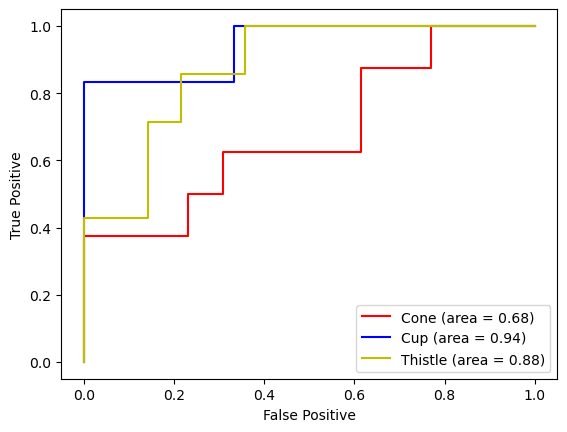

In [22]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], ovr.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plt.figure()
colors = ['r', 'b', 'y']

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], label="{0} (area = {1:0.2f})".format(binarizer.classes_[i], roc_auc[i]))
    
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.legend(loc="lower right")
plt.show()

### Feature Importances

In [13]:
#finding average importances across 10 runs

avg_importances = {pos : 0 for pos in positions}

start = time.time()
#sum importances over 10 runs
for i in range(10):
    
    rfc_fi = RandomForestClassifier(
                                class_weight='balanced',
                                criterion='entropy',
                                n_estimators=500,
                                max_features=0.5
                                )
    rfc_fi.fit(X_encoded, y)

    importance_values = rfc_fi.feature_importances_
    feat_names = ohe.get_feature_names_out(positions)

    #recombine feature names and importances into list of tuples with (gene position, SNP value, importance)
    feat_importances = []
    for i, f in enumerate(feat_names):
        split = f.split('_')
        feat_importances.append((split[0], split[1], importance_values[i]))

    #find summed importance per position
    summed_importances = {}
    for pos in positions:
        total = 0
        for p in feat_importances:
            if p[0] == pos: total += p[2]
        summed_importances[pos] = total
    
    for p in summed_importances:
        avg_importances[p] += summed_importances[p]

#divide values by 10 for average
for p in avg_importances:
    avg_importances[p] = avg_importances[p]/10
    
end = time.time()
print(end-start)

397.05150270462036


In [14]:
#sorting by importance
sorted_importances = sorted(avg_importances, key=avg_importances.get, reverse=True)
sorted_features = []
sorted_values = []
for p in sorted_importances:
    sorted_features.append(p)
    sorted_values.append(avg_importances[p])

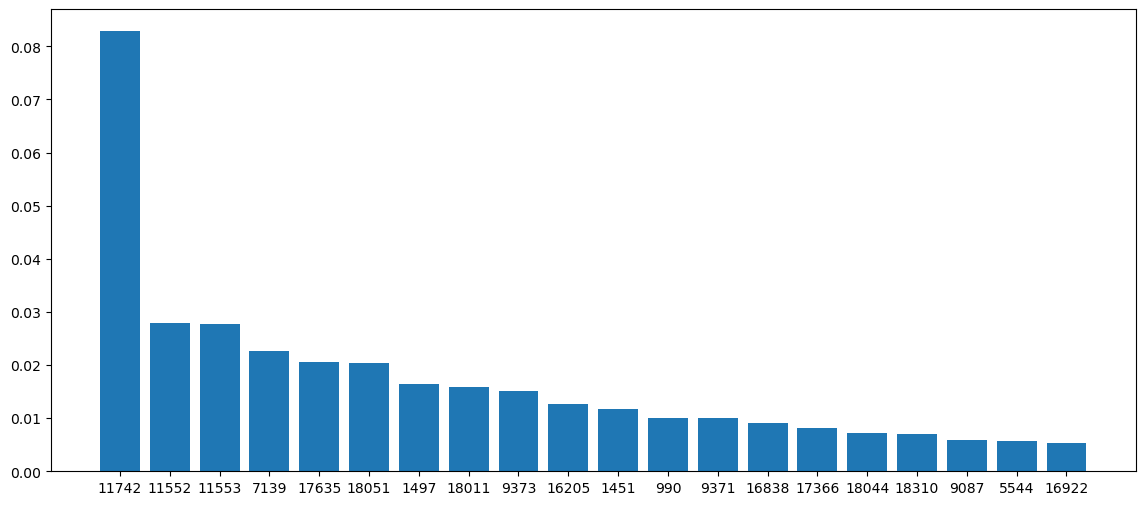

In [15]:
#top 20 bar plot
plt.figure(figsize=(14,  6))
plt.bar(sorted_features[:20], sorted_values[:20])
plt.show()

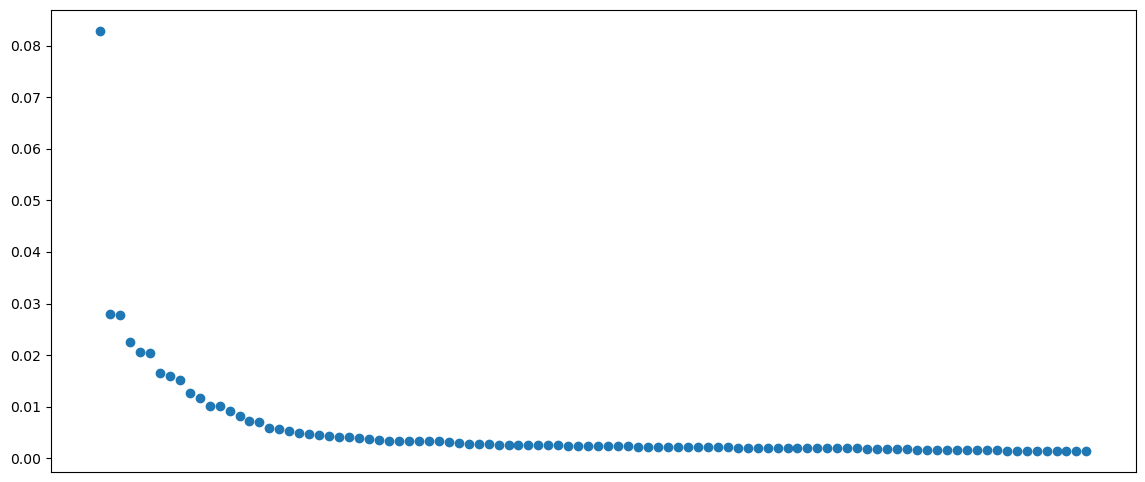

In [16]:
#elbow method from source 3 -> cutoff after top ~30
plt.figure(figsize=(14,  6))
plt.plot(sorted_features[:100], sorted_values[:100], 'o')
plt.xticks([])
plt.show()

In [28]:
# f = open("all_importances.txt", "w")
# for p in sorted_importances:
#     f.write(str(p) + ": " + str(avg_importances[p]) + "\n")
# f.close()

### Grid Search

In [17]:
# parameters = {'n_estimators': [10, 100, 250, 500, 1000], 'criterion': ['gini', 'entropy'],
#               'max_features': ['sqrt', 'log2', 0.1, 0.2, 0.33333, 0.5, None]}

# start = time.time()
# rfc_gs = RandomForestClassifier(class_weight='balanced')
# gs = GridSearchCV(rfc_gs, parameters, cv=5)
# gs.fit(X_tune_encoded, y_tune)
# end = time.time()

# print("time: " + str(end-start))
# print(gs.best_params_)

### Sources

In [1]:
# 1: https://link.springer.com/chapter/10.1007/978-3-030-89010-0_15
# 2: https://onlinelibrary.wiley.com/doi/am-pdf/10.1111/1755-0998.12773 
# 3: https://bmcgenomdata.biomedcentral.com/articles/10.1186/1471-2156-11-49